In [19]:
%%capture cap --no-stderr
# %env CUDA_VISIBLE_DEVICES=3
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy
import os
from functools import partial
from tqdm import tqdm

SAMPLE_COL = 16
SAMPLE_ROW = 16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

# IMG_H = 28
# IMG_W = 28
# IMG_C = 1
IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 1000
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUF = 65536

# DC_LR = 2.5e-04
# DC_LR = 1e-4
# DC_EPOCH = 512

W_LR = 2.0e-04
# W_LR = 1e-4
W_EPOCH = 256
WClipLo = -0.01
WClipHi = 0.01

is_recover_checkpoint = True

In [5]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)
# tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 10000)])

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[3], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 1 Logical GPUs


# Load Dataset

In [6]:
from os import listdir
from os.path import isfile, join

base_path = '/opt/shared-disk2/ml20_t16/labs/lab14-2/data/'
dataset_dir = 'img_align_celeba_png/img_align_celeba_png'
full_path = base_path + dataset_dir

file_list = [f for f in listdir(full_path) if isfile(join(full_path, f)) and f[-4:] == '.png']
# test_full_path_list = [join(full_path, f) for f in file_list if isfile(join(full_path, f)) and int(f[1:-4]) >= num_examples]
train_full_path_list = [join(full_path, f) for f in file_list if isfile(join(full_path, f)) and int(f[1:-4]) >= 0]
# test_name_list = [f[:-4] for f in file_list if isfile(join(full_path, f)) and int(f[1:-4]) >= num_examples]
train_name_list = [f[:-4] for f in file_list if isfile(join(full_path, f)) and int(f[1:-4]) >= 0]

print(len(train_full_path_list))
print(len(train_name_list))
print(train_full_path_list[:5])
print(train_name_list[:5])

202599
202599
['/opt/shared-disk2/ml20_t16/labs/lab14-2/data/img_align_celeba_png/img_align_celeba_png/000001.png', '/opt/shared-disk2/ml20_t16/labs/lab14-2/data/img_align_celeba_png/img_align_celeba_png/000002.png', '/opt/shared-disk2/ml20_t16/labs/lab14-2/data/img_align_celeba_png/img_align_celeba_png/000003.png', '/opt/shared-disk2/ml20_t16/labs/lab14-2/data/img_align_celeba_png/img_align_celeba_png/000004.png', '/opt/shared-disk2/ml20_t16/labs/lab14-2/data/img_align_celeba_png/img_align_celeba_png/000005.png']
['000001', '000002', '000003', '000004', '000005']


In [29]:
def map_load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (64, 64))
    img = img / 255.0
    return img

In [30]:
dataset = tf.data.Dataset.from_tensor_slices(train_full_path_list)
dataset = dataset.map(map_load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dsTrain = dataset.shuffle(BUF).batch(BATCH_SIZE, drop_remainder=True)

In [31]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

# Imporved WGAN
I've tried to add an additional convolution layer, modified the learning rate to 1e-4 and, changed the optimizer to Adam. However, all of them failed. The original model and learning rate performs best through all the methods I've tried.

In [32]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

According to the reuirement, I add ***gradient penalty*** to the loss funciton of discriminator. First I sample a weight matrix in the same size of the size of the generator's output. Fuse the fake and real images. Then calculate the gradient and apply L2-norm to get the result.

In [33]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.RMSprop(W_LR)
optimizer_d = keras.optimizers.RMSprop(W_LR)
# optimizer_g = keras.optimizers.Adam(W_LR, beta_1=0.5, beta_2=0.9)
# optimizer_d = keras.optimizers.Adam(W_LR, beta_1=0.5, beta_2=0.9)

@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpg:
        c0 = WG(z, training = True)

        # Real Image
        z1 = WD(c1, training = True)
        # Fake Image
        z0 = WD(c0, training = True)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)

    gradient_g = tpg.gradient(lg, WG.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, WG.trainable_variables))
    
    return lg, ld

def gradient_penalty(f, real, fake):
    # print(real.shape)
    # print(fake.shape)

    #  Sampling uniformly along straight lines between pairs of points sampled from the data distribution Pr and the generator distribution Pg
    def _smpale(a, b):
        shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
        alpha = tf.random.uniform(shape=shape, minval=0., maxval=1.)
        inter = (alpha * a) + ((1 - alpha) * b)
        inter.set_shape(a.shape)
        return inter
    
    x = _smpale(real, fake)
    # print(x.shape)
    with tf.GradientTape() as tape:
        tape.watch(x)
        pred = f(x)
    grad = tape.gradient(pred, x)
    # A differentiable function is 1-Lipschtiz if and only if it has gradients with norm at most 1 everywhere and directly constraining the gradient norm of the critic’s output with respect to its input
    norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
    gp = tf.reduce_mean((norm - 1.)**2)

    return gp

@tf.function
def WDTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpd:
        # c1: Real Image, c0: Fake Image
        # print(f"z shape: {z.shape}")
        c0 = WG(z, training = True)

        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)

        ld = tf.reduce_mean(z0)
        # Loss of Generator
        lg = - ld
        
        # Gradient Penalty
        gp = gradient_penalty(partial(WD, training=True), c1, c0)
        # Penalty coefficient
        labmda = 10
        # Loss of Discriminator
        # ld = ld - tf.reduce_mean(z1)
        ld = ld - tf.reduce_mean(z1) + gp * labmda

    gradient_d = tpd.gradient(ld, WD.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, WD.trainable_variables))
    # clipping
    # for v in WD.trainable_variables: 
    #     v.assign(tf.clip_by_value(v, WClipLo, WClipHi))
    
    return lg, ld

 # Record The Loss of Each Epoch

In [34]:
import pandas as pd
import numpy as np

class LossRecord:
    def __init__(self, len, restore_path='/home/ccchen/sychou/labs/lab14-2/exp3/record/loss.csv'):
        # print("Init")
        dummy = np.zeros(len)
        self.path = restore_path

        self.cols = ['epoch', 'loss_g', 'loss_d']
        self.losses = pd.DataFrame(columns=self.cols)
        self.losses['epoch'] = dummy
        self.losses['loss_g'] = dummy
        self.losses['loss_d'] = dummy

    def restore(self):
        try:
            print("Recover from Record")
            losses_old = pd.read_csv(self.path, index_col=0)
            # display(losses_old.head())
            self.losses.update(losses_old)
            # display(self.losses)

        except:
            print("No CSV")

    def insert_loss(self, epoch, loss_g, loss_d):
        self.losses.at[epoch, 'epoch'] = epoch
        self.losses.at[epoch, 'loss_g'] = loss_g
        self.losses.at[epoch, 'loss_d'] = loss_d
        self.losses.to_csv(self.path)

    def get_df(self):
        return self.losses

In [35]:
ls = LossRecord(len=W_EPOCH)
if is_recover_checkpoint:
    ls.restore()
display(ls.get_df().head())

Recover from Record


,epoch,loss_g,loss_d
0,0.0,-1.108132,-0.402996
1,1.0,-3.895655,-1.190933
2,2.0,-5.116018,-1.925193
3,3.0,-6.857982,-1.717703
4,4.0,-9.145994,-0.011660


# Checkpoint

In [37]:
checkpoint_path = "/mnt/large-disk/sychou/lab14-2/checkpoint3"
ckpt = tf.train.Checkpoint(g=WG,
                           d=WD,
                           opt_g = optimizer_g,
                           opt_d = optimizer_d)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=150)

In [ ]:
start_epoch = 0
latest = None
if is_recover_checkpoint:
    latest = ckpt_manager.latest_checkpoint
if latest:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print("Recover from Checkpint")
    print(latest)
    ckpt.restore(latest)
# start_epoch = 9
# ckpt.restore('/mnt/large-disk/sychou/lab14-2/checkpoint3/ckpt-210')

Recover from Checkpint
/mnt/large-disk/sychou/lab14-2/checkpoint3/ckpt-40


# Train Model
Since I use ```runipy``` to execute the notebook, there is no output record here.

In [40]:
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)
img_abs_path = '/home/ccchen/sychou/labs/lab14-2/exp3'
print(img_abs_path)

/home/ccchen/sychou/labs/lab14-2/exp3


In [ ]:
%%capture cap --no-stderr
wlg = [None] * W_EPOCH #record loss of g for each epoch
wld = [None] * W_EPOCH #record loss of d for each epoch
wsp = [None] * W_EPOCH #record sample images for each epoch

# rsTrain = float(BATCH_SIZE) / float(len(iTrain))
rsTrain = float(BATCH_SIZE) / float(len(train_full_path_list))
ctr = 0
for ep in range(start_epoch, W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    print(f"Epoch {ep}")
    pbar = tqdm(dsTrain)
    for c1 in pbar:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0

        pbar.set_description(f"EP{ep} Loss G: {np.round(lg.numpy(), 2)} | Loss D: {np.round(ld.numpy(), 2)}")
    pbar.close()

    ckpt_manager.save()
    ls.insert_loss(ep, lgt * rsTrain, ldt * rsTrain)
    display(ls.get_df().head(10))

    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        img_abs_path+"/imgs/w_%04d.png" % ep
    )
    wsp[ep] = img
    if (ep+1) % 32 == 0:
        # plt.imshow(img[..., 0], cmap = "gray")
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

EP40 Loss G: -43.529998779296875 | Loss D: -1.2000000476837158: : 202it [01:31,  2.20it/s]
EP41 Loss G: -43.2400016784668 | Loss D: -1.3200000524520874: : 101it [00:46,  2.44it/s] 

Since the output a the 256 epoch is very bad and the losses are very high, I restore the model to 210 epoch.

In [110]:
selected_epoch = 210
img_path = img_abs_path+"/imgs"
picked_img_path = img_abs_path+"/picked"

# Make GIF
Through the output gif file, I found that several style change occured during training. Some cells show a man in the earlier epochs, but it shows woman suddenly in the later epochs. It may occur ***mode collapse***

All output images, gif... are here

[https://drive.google.com/drive/folders/1ut_X5EtD7scdxCP2atfC5BQdhwUQKT17?usp=sharing](https://drive.google.com/drive/folders/1ut_X5EtD7scdxCP2atfC5BQdhwUQKT17?usp=sharing)

Link of GIF:

[https://drive.google.com/file/d/14wun7Yj_uGbj-qrArzqw6gsIyLEKqmt1/view?usp=sharing](https://drive.google.com/file/d/14wun7Yj_uGbj-qrArzqw6gsIyLEKqmt1/view?usp=sharing)

In [87]:
from os import listdir
from os.path import isfile, join

file_list = [f for f in listdir(img_path) if isfile(join(img_path, f)) and f[-4:] == '.png' and f[:2] == 'w_']
gen_full_path_list = [join(img_path, f) for f in file_list if isfile(join(img_path, f)) and int(f[-8:-4]) < selected_epoch]

print(file_list[:5])
print(gen_full_path_list[:5])
print(len(file_list))
print(len(gen_full_path_list))

['w_0000.png', 'w_0001.png', 'w_0002.png', 'w_0003.png', 'w_0004.png']
['/home/ccchen/sychou/labs/lab14-2/exp3/imgs/w_0000.png', '/home/ccchen/sychou/labs/lab14-2/exp3/imgs/w_0001.png', '/home/ccchen/sychou/labs/lab14-2/exp3/imgs/w_0002.png', '/home/ccchen/sychou/labs/lab14-2/exp3/imgs/w_0003.png', '/home/ccchen/sychou/labs/lab14-2/exp3/imgs/w_0004.png']
253
210


In [88]:
def load_image64(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    return img

Since the GIF is too big, I don't show it here

In [116]:
wsp = list(map(load_image64, gen_full_path_list))
utMakeGif(np.array(wsp), picked_img_path+"/wgan.gif", duration = 2)

t:   0%|          | 0/210 [00:00<?, ?it/s, now=None]MoviePy - Building file /home/ccchen/sychou/labs/lab14-2/exp3/picked/wgan.gif with imageio.


# Plot Loss Curve of Generator and Discriminator


In [119]:
wld = ls.get_df()['loss_d']
wlg = ls.get_df()['loss_g']

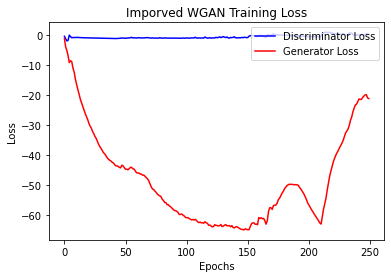

In [120]:
plt.plot(range(len(wld)), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(len(wlg)), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Imporved WGAN Training Loss")
plt.show()


# Restore Best Model and Generate Images
Most of the generated image are bad, but some of them are quite great.

Generated images are here: 

[https://drive.google.com/drive/folders/1ber_HGfD-BVxnl_4QtDmbUzA34cakUrY?usp=sharing](https://drive.google.com/drive/folders/1ber_HGfD-BVxnl_4QtDmbUzA34cakUrY?usp=sharing)

Cherry picks:

[https://drive.google.com/drive/folders/1-UPNIUhO7jun1gg9i6mENTYTut2GUIdT?usp=sharing](https://drive.google.com/drive/folders/1-UPNIUhO7jun1gg9i6mENTYTut2GUIdT?usp=sharing)

Puzzel:

[https://drive.google.com/file/d/1H-6Z3AXay_NoVM2HJcrObx98ABBTNoU8/view?usp=sharing](https://drive.google.com/file/d/1H-6Z3AXay_NoVM2HJcrObx98ABBTNoU8/view?usp=sharing)

(-0.5, 1023.5, 1023.5, -0.5)

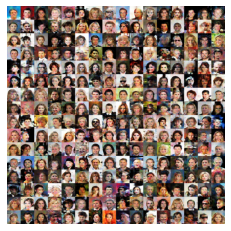

In [115]:
restore_ep = selected_epoch
ckpt.restore(f'/mnt/large-disk/sychou/lab14-2/checkpoint3/ckpt-{restore_ep}')

random_code = tf.random.normal((SAMPLE_NUM, Z_DIM))
out = WG(random_code, training = False)
for i, img in enumerate(out):
    path = picked_img_path+f'/p_{i}.png'
    imageio.imwrite(path, (img * 255.0).numpy().astype(np.uint8))

img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        picked_img_path+'/puzzel.png'
    )
plt.imshow(img)
plt.axis("off")

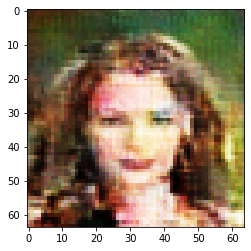

In [104]:
plt.imshow(out[97])